In [31]:
import os
from pathlib import Path
from datetime import datetime
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)

from build_dataset import create_tile, calc_tile_offsets
from build_dataset import compute_pixel_scale, coord2px, inside_tile
from build_dataset import get_files_from_folder, extract_dates_pattern_airmass_rgb_20200101_0000
from medicane_utils.load_files import load_cyclones_track_noheader
from medicane_utils.geo_const import latcorners, loncorners, x_center, y_center, basemap_obj


### Carico i cicloni

In [ ]:
tracks_file = "./TRACKS_CL7.dat"  
df_tracks = load_cyclones_track_noheader(tracks_file)
df_tracks['time'] = pd.to_datetime(df_tracks['time'])
df_tracks.shape

(139135, 4)

In [3]:
df_tracks = df_tracks[df_tracks['time'] > datetime(2011, 1, 1)]
df_tracks.shape

(34584, 4)

In [4]:
tracks_df_coord = df_tracks[
    (df_tracks['lat'] >= latcorners[0]) & (df_tracks['lat'] <= latcorners[1]) &
    (df_tracks['lon'] >= loncorners[0]) & (df_tracks['lon'] <= loncorners[1])
]
tracks_df_coord.shape

(27318, 4)

In [5]:
df_med = pd.read_csv('medicane_validi.csv')
df_med['Start_Date'] = pd.to_datetime(df_med['Start_Date'])
df_med['End_Date'] = pd.to_datetime(df_med['End_Date'])
df_med


,Unnamed: 0,Medicane,Start_Date,End_Date
0,1,Rolf,2011-11-03,2011-11-09
1,3,Ilona,2014-01-19,2014-01-22
2,4,Qendresa,2014-11-04,2014-11-11
3,5,Trixie,2016-10-26,2016-11-02
4,6,Numa,2017-11-14,2017-11-20
5,7,Zorbas,2018-09-25,2018-10-01
6,8,Ianos,2020-09-14,2020-09-22
7,10,Apollo,2021-10-24,2021-11-02
8,11,Blas,2021-11-06,2021-11-16
9,12,Helios,2023-02-08,2023-02-11


In [6]:
# Partiamo da una colonna vuota
tracks_df_coord['Medicane'] = None

# Per ogni intervallo nel df_piccolo, assegna il nome alle righe che rientrano
for i, row in df_med.iterrows():
    start = row['Start_Date']
    end = row['End_Date'] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # include tutto il giorno finale
    nome = row['Medicane']
    print(start, end, nome, end=' ')
    
    m_start = tracks_df_coord['time'] >= start
    m_end = tracks_df_coord['time'] <= end
    mask = m_start & m_end
    #print(m_start.sum(), m_end.sum(), mask.sum())
    #display(tracks_df_coord[mask])
    tracks_df_coord.loc[mask, 'Medicane'] = nome

2011-11-03 00:00:00 2011-11-09 23:59:59 Rolf 2014-01-19 00:00:00 2014-01-22 23:59:59 Ilona 2014-11-04 00:00:00 2014-11-11 23:59:59 Qendresa 2016-10-26 00:00:00 2016-11-02 23:59:59 Trixie 2017-11-14 00:00:00 2017-11-20 23:59:59 Numa 2018-09-25 00:00:00 2018-10-01 23:59:59 Zorbas 2020-09-14 00:00:00 2020-09-22 23:59:59 Ianos 2021-10-24 00:00:00 2021-11-02 23:59:59 Apollo 2021-11-06 00:00:00 2021-11-16 23:59:59 Blas 2023-02-08 00:00:00 2023-02-11 23:59:59 Helios 2023-02-25 00:00:00 2023-03-04 23:59:59 Juliette 2023-09-04 00:00:00 2023-09-11 23:59:59 Daniel 

/tmp/ipykernel_2348007/2950291860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_coord['Medicane'] = None


In [7]:
tracks_df_coord[~tracks_df_coord['Medicane'].isna()]['Medicane'].unique()

array(['Rolf', 'Ilona', 'Qendresa', 'Trixie', 'Numa', 'Zorbas', 'Ianos'],
      dtype=object)

In [8]:
tracks_df_coord['year'] = tracks_df_coord['time'].dt.year
tracks_df_coord['month']= tracks_df_coord['time'].dt.month
tracks_df_coord['day']  = tracks_df_coord['time'].dt.day
tracks_df_coord['hour'] = tracks_df_coord['time'].dt.hour

/tmp/ipykernel_2348007/3193182999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_coord['year'] = tracks_df_coord['time'].dt.year
/tmp/ipykernel_2348007/3193182999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_coord['month']= tracks_df_coord['time'].dt.month
/tmp/ipykernel_2348007/3193182999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

### Leggo i file immagine

In [9]:
input_dir = "../fromgcloud"
#output_dir = "../airmassRGB/supervised" 
#os.makedirs(output_dir, exist_ok=True)

filenames = get_files_from_folder(folder=input_dir, extension="png")
#print(f"Trovati {len(filenames)} files")

file_metadata = []
for fname in filenames:
    start_dt = extract_dates_pattern_airmass_rgb_20200101_0000(fname.name)
    file_metadata.append((fname, start_dt))

sorted_files = sorted(file_metadata, key=lambda x: x[1])  # Ordina per start_dt
#random_fnames =  [item[0] for item in file_metadata]
sorted_filenames = [item[0] for item in sorted_files]
print(f" Ci sono {len(sorted_filenames)} files.")

 Ci sono 117764 files.


In [10]:
fsel = [f for f in file_metadata if f[1] == datetime(2020, 9, 17, 3, 40)]

In [11]:
fsel

[(PosixPath('../fromgcloud/airmass_rgb_20200917_0340.png'),
  datetime.datetime(2020, 9, 17, 3, 40))]

In [12]:
img = Image.open(fsel[0][0])

### test tile creation

In [13]:
tiles, offsets = create_tile(img)  #tupla:( list:[<PIL.Image.Image image mode=RGB size=224x224>,...] , [(0, 0), (112, 0), (224, 0), (336, 0), ... (0, 112), (112, 112), (224, 112), (336, 112), )


In [16]:
dt_ = fsel[0][1]
dt_

datetime.datetime(2020, 9, 17, 3, 40)

In [18]:
subset_df = tracks_df_coord[
        (tracks_df_coord['year'] == dt_.year) &
        (tracks_df_coord['month'] == dt_.month) &
        (tracks_df_coord['day'] == dt_.day) &
        (tracks_df_coord['hour'] == dt_.hour)
    ]
subset_df

,id_cyc,lat,lon,time,Medicane,year,month,day,hour
137910,00001702,37.069,17.782,2020-09-17 03:00:00,Ianos,2020,9,17,3


In [32]:
[lat1, lon1] = subset_df[['lat', 'lon']].values[0]
lat1, lon1

(37.069, 17.782)

In [76]:
from mpl_toolkits.basemap import Basemap
latcorners = [30, 48]
loncorners = [-7, 46]
basemap_obj = Basemap(
    projection='geos',
    rsphere=(6378137.0, 6356752.3142),
    resolution='i',
    area_thresh=10000.,
    lon_0=9.5,
    satellite_height=3.5785831E7,
    llcrnrlon=loncorners[0],
    llcrnrlat=latcorners[0],
    urcrnrlon=loncorners[1],
    urcrnrlat=latcorners[1])
x_center, y_center = basemap_obj(9.5, 0)
lat_min, lat_max = latcorners
lon_min, lon_max = loncorners


In [ ]:
x0, y0 = basemap_obj(lon_min, lat_min)
x1, y1 = basemap_obj(lon_max, lat_max)
# Sottraggo l'offset
x0 -= x_center
y0 -= y_center
x1 -= x_center
y1 -= y_center

In [39]:
x_geo, y_geo, x_center, y_center, Xlocal, Ylocal

(2230754.3769015903,
 604865.1834455738,
 1523293.879576,
 -3067379.95726758,
 707460.4973255903,
 3672245.140713154)

In [59]:
Xmin, Ymin, px_scale_x, px_scale_y = compute_pixel_scale(basemap_obj, latcorners, loncorners, big_image_w=1290, big_image_h=420)
#x_pix, y_pix = coord2px(lat1, lon1, px_scale_x, px_scale_y, Xmin, Ymin)
px_scale_x*1000, px_scale_y*1000

(0.27830872818492597, 0.2957015534154286)

In [71]:
x_geo, y_geo = basemap_obj(lon1, lat1)
Xlocal = x_geo - Xmin
Ylocal = y_geo - Ymin
x_pix = Xlocal * px_scale_x
y_pix = Ylocal * px_scale_y
x_pix, y_pix

(620.8384135284373, 201.89917302638784)

In [72]:


def draw_tiles_and_center(
    pil_image: Image.Image,
    tile_size=224,
    stride=112,
    cyclone_center=None,
    box_color=(0, 255, 0),
    point_color=(255, 0, 0),
    point_radius=4
):
    """
    Disegna, sull'immagine `pil_image`, una serie di riquadri (224×224 di default)
    generati con stride specificato, in modo identico alla suddivisione in tile.

    Se `cyclone_center` è una tupla (cx, cy), disegna un punto rosso in tale posizione.

    Ritorna l'immagine PIL con i disegni sopra.
    """

    # Richiediamo gli offset dai tile (non ci serve la lista di sub-tile veri e propri)
    default_offsets = calc_tile_offsets()

    # Creiamo una copia su cui disegnare
    out_img = pil_image.copy()
    draw = ImageDraw.Draw(out_img)

    # Disegniamo i rettangoli
    for (x_off, y_off) in default_offsets:
        x1, y1 = x_off, y_off
        x2, y2 = x_off + tile_size, y_off + tile_size
        draw.rectangle(
            [(x1, y1), (x2, y2)],
            outline=box_color,
            width=2)

    # Se c'è un centro da disegnare
    if cyclone_center is not None:
        cx, cy = cyclone_center
        # Disegniamo un piccolo cerchio intorno al centro
        draw.ellipse(
            [
                (cx - point_radius, cy - point_radius),
                (cx + point_radius, cy + point_radius)
            ],
            fill=point_color
        )

    return out_img

In [73]:
y_pix = 420 - y_pix
x_pix = 1290 - x_pix

In [74]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img,
    cyclone_center=center_px
)

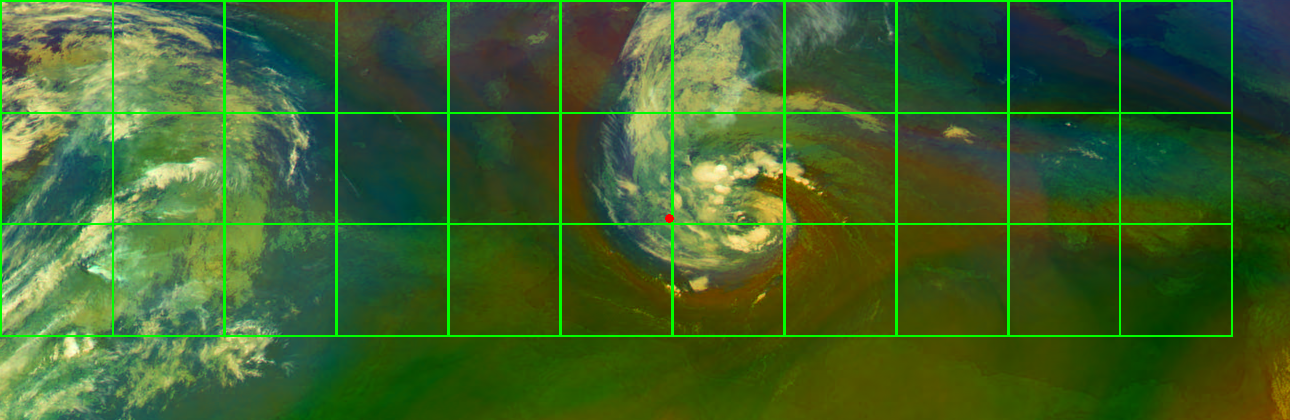

In [75]:
display(out_img)

In [ ]:
# testare per un ciclone e un medicane
# accuracy sul training test